In [24]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import pyxirr
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker as tick
plt.style.use('seaborn-bright')
plt.style.use('seaborn-whitegrid')

class pct(float):
    def __str__(self):
        return '{:.4%}'.format(self)

In [25]:
# READ TRANSACTIONS FROM CSV
input_data = pd.read_csv('./test-portfolio.csv', sep=',', index_col='Date', parse_dates=True).sort_index()

In [26]:
# UTILITIES
tickers = input_data.Ticker.unique()
tickers = tickers[tickers != 'CASH$']
tickers.sort()
start_date = input_data.index[0].date()
end_date = datetime.date.today()
timeline = pd.date_range(start=start_date, end=end_date)
years = timeline.shape[0]/365
day = datetime.timedelta(days=1)
sec_order = ['purchase', 'sale', 'split']
cash_order = ['deposit', 'withdrawal', 'dividend', 'reinvestment']

In [27]:
# INITIALISE DATAFRAMES
sec_trans = pd.DataFrame(0, columns=tickers, index = timeline)
splits = pd.DataFrame(1, columns=tickers, index = timeline)
holdings = pd.DataFrame(0, columns=tickers, index = timeline)
account = pd.DataFrame(0, columns=['ext_mov', 'inv_cap', 'int_mov', 'holding'], index = timeline)
market_values = yf.download(list(tickers), start=start_date + day, end=end_date + day)['Adj Close']
market_values = market_values.reindex(index=timeline, method='nearest')

[*********************100%***********************]  3 of 3 completed


In [28]:
# ORDER FUNCTIONS
def deposit(date, trans):
    account.ext_mov.loc[date] = account.ext_mov.loc[date] + trans.Quantity * trans.Price
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee

def withdrawal(date, trans):
    account.ext_mov.loc[date] = account.ext_mov.loc[date] - trans.Quantity * trans.Price
    account.int_mov.loc[date] = account.int_mov.loc[date] - trans.Quantity * trans.Price - trans.Fee
    
def reinvestment(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee

def purchase(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] - trans.Quantity * trans.Price - trans.Fee
    sec_trans.loc[date, trans.Ticker] = sec_trans.loc[date, trans.Ticker] + trans.Quantity

def sell(date, trans):
    account.int_mov.loc[date] = account.int_mov.loc[date] + trans.Quantity * trans.Price - trans.Fee
    sec_trans.loc[date, trans.Ticker] = sec_trans.loc[date, trans.Ticker] - trans.Quantity

def dividend(date, trans):
    reinvestment(date, trans)

def ssplit(date, trans):
    splits.loc[date] = trans.Price

# TRANSACTION SORTING FUNCTION
def event(date, trans):
    if trans.Order == 'purchase':
        purchase(date, trans)
    elif trans.Order == 'sale':
        sell(date, trans)
    elif trans.Order == 'split':
        ssplit(date, trans)
    elif trans.Order == 'deposit':
        deposit(date, trans)
    elif trans.Order == 'withdrawal':
        withdrawal(date, trans)
    elif trans.Order == 'reinvestment':
        reinvestment(date, trans)
    elif trans.Order == 'dividend':
        dividend(date, trans)
    else:
        pass

# DATA FILLING FUNCTIONS
def backfill(df, delta):
    for i in range(df.shape[0]):
        prev = 0
        if i > 0:
            prev = df.iloc[i-1]
        df.iloc[i] = prev + delta.iloc[i]

def forwprod(df):
    for i in reversed(range(df.shape[0])):
        nex = 1
        if i < df.shape[0]-2:
            nex = df.iloc[i+1]
        df.iloc[i] = nex * df.iloc[i]

In [29]:
# DOWNLOAD AND RECORD SPLITS DATA
for ticker in tickers:
    spls = yf.Ticker(ticker).splits.loc[start_date + day : end_date + day]
    for date, split in spls.iteritems():
        input_data.loc[date] = [ticker, 'split', split, np.nan, 0]

# PROCESS SECURITY TRANSACTIONS
for date, transaction in input_data[input_data.Order.isin(sec_order)].iterrows():
    event(date, transaction)

# FILL HOLDINGS
backfill(holdings, sec_trans*splits)

# DOWNLOAD AND RECORD DIVIDENDS DATA
for ticker in tickers:
    divs = yf.Ticker(ticker).dividends.loc[start_date + day : end_date + day]
    for date, div in divs.iteritems():
        input_data.loc[date] = [ticker, 'dividend', div, holdings.loc[date, ticker], 0]

# PROCESS CASH TRANSACTIONS
for date, transaction in input_data[input_data.Order.isin(cash_order)].iterrows():
    event(date, transaction)

# FILL EXTERNAL AND INTERNAL ACCOUNT MOVEMENTS
backfill(account.inv_cap, account.ext_mov)
backfill(account.holding, account.int_mov)

/opt/homebrew/Caskroom/miniforge/base/envs/fin/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [30]:
# OUTPUT DATA
holdings_values = pd.DataFrame((holdings * market_values), columns=tickers, index=timeline)
holdings_values['CASH$'] = account.holding

portfolio = pd.DataFrame(0, columns=['Value'], index = timeline)
portfolio['Value'] = holdings_values.sum(axis=1)
portfolio['P/L'] = portfolio['Value'] - account.inv_cap
portfolio['%P/L'] = portfolio['P/L'] / account.inv_cap
portfolio['%day'] = (portfolio['Value']- account.ext_mov).pct_change()
portfolio['Log Ret'] = np.log((portfolio['Value'] - account.ext_mov) / portfolio['Value'].shift(1))

cash_flows = - account.ext_mov
cash_flows.iloc[-1] = portfolio['Value'].iloc[-1]

asset_allocation = holdings_values.copy()
asset_allocation = asset_allocation.divide(portfolio['Value'], axis=0)

In [31]:
xirr = pyxirr.xirr(cash_flows.index, cash_flows.values)
xirr_ann = (1+xirr)**(1/years)-1
print('XIRR:', pct(xirr), '\nAnnualised XIRR', pct(xirr_ann))

XIRR: 37.5253% 
Annualised XIRR 19.3656%


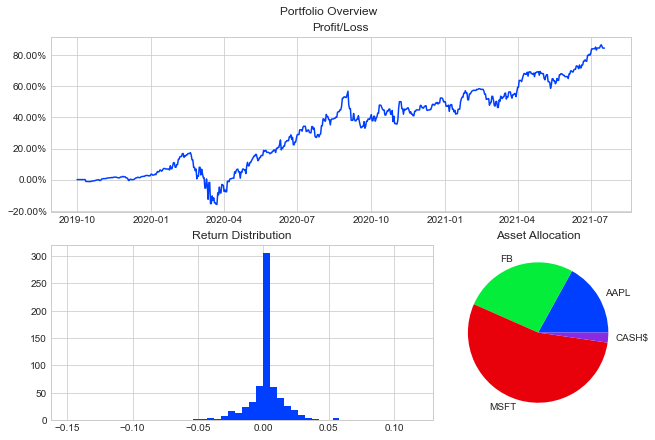

In [32]:
fig = plt.figure(constrained_layout=True)

fig.set_size_inches(9,6)
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[1:, -1])

fig.suptitle("Portfolio Overview")
ax1.set_title('Profit/Loss')
ax1.plot(portfolio['%P/L'])
ax1.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
ax2.set_title('Return Distribution')
ax2.hist(portfolio['Log Ret'], bins=50)
ax3.set_title('Asset Allocation')
ax3.pie(asset_allocation.iloc[-1], labels=asset_allocation.columns)
plt.show()

plt.show()